In [1]:
import numpy as np
import pandas as pd
import csv
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import learning_curve

In [2]:
# Load in all ML models
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [3]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)

In [4]:
# Load all data in
data_dir = './data'
train_data_raw = pd.read_csv(data_dir + '/train.csv')
train_label_raw = pd.read_csv(data_dir + '/train_labels.csv')
test_data_raw = pd.read_csv(data_dir + '/test.csv')
specs = pd.read_csv(data_dir + '/specs.csv')

In [5]:
# Extract Assessment data for training and test
train_data_raw = train_data_raw[train_data_raw['type'] == 'Assessment'].reset_index(drop=True)
test_data_raw = test_data_raw[test_data_raw['type'] == 'Assessment'].reset_index(drop=True)

In [6]:
print('Train data size: ', train_data_raw.shape)
print('Test data size: ', test_data_raw.shape)

Train data size:  (925345, 11)
Test data size:  (102627, 11)


In [7]:
# Preprocess train data
preprocess_train_data = pd.DataFrame()
ids_list = list(train_label_raw['installation_id'].unique())
sessions_list = list(train_label_raw['game_session'].unique())
for k, group in train_data_raw.groupby(['installation_id', 'game_session']):
    if group['installation_id'].iloc[0] in ids_list and group['game_session'].iloc[0] in sessions_list:
        df = group.sort_values(by=['event_count', 'game_time'])
        event_count = int(df['event_count'].iloc[-1])
        duration = int(df['game_time'].iloc[-1])
        installation_id = df['installation_id'].iloc[0]
        game_session = df['game_session'].iloc[0]
        title = df['title'].iloc[0]
        game_type = df['type'].iloc[0]
        world = df['world'].iloc[0]
        avg_event_code = df['event_code'].astype(np.int64).sum() / event_count
        intersec = train_label_raw[(train_label_raw['installation_id'] == installation_id) & 
                                    (train_label_raw['game_session'] == game_session)]
        accuracy_group = intersec['accuracy_group'].iloc[0]
        num_correct = intersec['num_correct'].iloc[0]
        num_incorrect = intersec['num_incorrect'].iloc[0]
        accuracy = intersec['accuracy'].iloc[0]
        preprocess_train_data = preprocess_train_data.append(pd.DataFrame({'installation_id': [installation_id], 
                                         'game_session': [game_session],
                                         'event_count': [event_count], 
                                         'duration': [duration],                                        
                                         'title': [title],
                                         'type': [game_type],
                                         'world': [world],
                                         'avg_event_code': [avg_event_code],
                                         'num_correct': [num_correct],
                                         'num_incorrect': [num_incorrect],
                                         'accuracy': [accuracy],
                                         'accuracy_group': [accuracy_group]}), ignore_index=True)  

In [8]:
# Convert categorical feature into numerical feature
def title_to_numeric(x):
    if x=='Mushroom Sorter (Assessment)':
        return 1
    if x=='Bird Measurer (Assessment)':
        return 2
    if x=='Cauldron Filler (Assessment)':
        return 3
    if x=='Chest Sorter (Assessment)':
        return 4
    if x=='Cart Balancer (Assessment)':
        return 5

In [9]:
# Convert categorical feature into numerical feature
def world_to_numeric(x):
    if x=='TREETOPCITY':
        return 1
    if x=='MAGMAPEAK':
        return 2
    if x=='CRYSTALCAVES':
        return 3

In [10]:
preprocess_train_data['title_num'] = preprocess_train_data['title'].apply(title_to_numeric)
preprocess_train_data['world_num'] = preprocess_train_data['world'].apply(world_to_numeric)

In [11]:
# Feature extraction
X = preprocess_train_data[['event_count', 'avg_event_code',
                           'duration', 'title_num', 'world_num']]
y = preprocess_train_data['accuracy_group']

In [12]:
# Normalize the raw data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
X

array([[-3.91580541e-01, -9.26186107e-01, -2.77176467e-02,
        -1.41716289e+00, -1.18050206e+00],
       [ 1.06932660e+00,  9.64199447e-01, -2.00573658e-05,
        -7.28494057e-01, -1.18050206e+00],
       [-2.63537560e-02, -1.89000527e-01, -2.22698216e-02,
        -1.41716289e+00, -1.18050206e+00],
       ...,
       [ 3.38873029e-01, -6.32931888e-02, -8.95758058e-03,
        -3.98252242e-02, -4.05336425e-02],
       [ 1.35027028e+00,  1.43189605e+00,  1.40428550e-02,
        -1.41716289e+00, -1.18050206e+00],
       [ 1.12551534e+00,  4.68475713e-01,  3.50238813e-03,
        -3.98252242e-02, -4.05336425e-02]])

In [14]:
# Get train and test data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

In [15]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(12383, 5) (12383,) (5307, 5) (5307,)


##########################################################
Approach1: Classification problem, compare different classification models performance

In [16]:
# Store all results into list for later plotting
clf = ['Logistic Regression', 'Decision Tree', 'Random Forest','Linear SVM', 'RBF SVM', 
       'KNN', 'Gaussian Naive Bayes', 'MLP']
acc = []
training_time = []
pred_time = []

In [17]:
# Training a Logistic Regression classifier and predict
# k-fold cross validation accuracy
k = 5
lr_model = LogisticRegression(random_state=0)
scores = cross_val_score(lr_model, X, y, cv=k)
avg_score = sum(scores) / len(scores)
print('Logistic Regression accuracy: ', avg_score)

# Compute confusion matrix 
start_train = time.time()
lr_model = LogisticRegression(random_state=0).fit(X_train, y_train)
tt = time.time() - start_train
start_pred = time.time()
lr_pred = lr_model.predict(X_val) 
pt = time.time() - start_pred
cm = confusion_matrix(y_val, lr_pred, labels=[3, 2, 1, 0]) 
print('Logistics Regression confusion matrix: \n')
print(cm)
print('\n')
print('Training time: ', tt)
print('Prediction time: ', pt)

# Append all results to list
acc.append(avg_score)
training_time.append(tt)
pred_time.append(pt)

Logistic Regression accuracy:  0.6401921989824759
Logistics Regression confusion matrix: 

[[2395    0   15  228]
 [ 477    0   18  175]
 [ 257    0  204  266]
 [ 372    0  115  785]]


Training time:  0.26880717277526855
Prediction time:  0.0005266666412353516


In [18]:
# Training a Decision-Tree classifier and predict
# k-fold cross validation accuracy
k = 5
dtree_model = DecisionTreeClassifier(max_depth = 2)
scores = cross_val_score(dtree_model, X, y, cv=k)
avg_score = sum(scores) / len(scores)
print('Decision Tree accuracy: ', avg_score)

# Compute confusion matrix 
start_train = time.time()
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train, y_train)
tt = time.time() - start_train
start_pred = time.time()
dtree_pred = dtree_model.predict(X_val) 
pt = time.time() - start_pred
cm = confusion_matrix(y_val, dtree_pred, labels=[3, 2, 1, 0]) 
print('Decision Tree confusion matrix: \n')
print(cm)
print('\n')
print('Training time: ', tt)
print('Prediction time: ', pt)

# Append all results to list
acc.append(avg_score)
training_time.append(tt)
pred_time.append(pt)

Decision Tree accuracy:  0.6119276427360091
Decision Tree confusion matrix: 

[[2088    0  249  301]
 [ 223    0  267  180]
 [  35    0  314  378]
 [ 301    0  111  860]]


Training time:  0.00863194465637207
Prediction time:  0.0004973411560058594


In [19]:
# Training a Random Forest classifier and predict
# k-fold cross validation accuracy
k = 5
rf_model = RandomForestClassifier(max_depth=2, random_state=0)
scores = cross_val_score(rf_model, X, y, cv=k)
avg_score = sum(scores) / len(scores)
print('Random Forest accuracy: ', avg_score)

# Compute confusion matrix 
start_train = time.time()
rf_model = RandomForestClassifier(max_depth=2, random_state=0).fit(X_train, y_train)
tt = time.time() - start_train
start_pred = time.time()
rf_pred = rf_model.predict(X_val) 
pt = time.time() - start_pred
cm = confusion_matrix(y_val, rf_pred, labels=[3, 2, 1, 0]) 
print('Random Forest confusion matrix: \n')
print(cm)
print('\n')
print('Training time: ', tt)
print('Prediction time: ', pt)

# Append all results to list
acc.append(avg_score)
training_time.append(tt)
pred_time.append(pt)

Random Forest accuracy:  0.6226116449971737
Random Forest confusion matrix: 

[[2482    0   18  138]
 [ 466    0   38  166]
 [ 209    0  126  392]
 [ 565    0   25  682]]


Training time:  0.4677102565765381
Prediction time:  0.03390979766845703


In [20]:
# Training a linear SVM classifier and predict  
# k-fold cross validation accuracy
k = 5
svm_model_linear = SVC(kernel = 'linear', C = 1)
scores = cross_val_score(svm_model_linear, X, y, cv=k)
avg_score = sum(scores) / len(scores)
print('Linear SVM accuracy: ', avg_score)

# Compute confusion matrix 
start_train = time.time()
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
tt = time.time() - start_train
start_pred = time.time()
svm_pred = svm_model_linear.predict(X_val)
pt = time.time() - start_pred
cm = confusion_matrix(y_val, svm_pred, labels=[3, 2, 1, 0]) 
print('Linear SVM confusion matrix: \n')
print(cm)
print('\n')
print('Training time: ', tt)
print('Prediction time: ', pt)

# Append all results to list
acc.append(avg_score)
training_time.append(tt)
pred_time.append(pt)

Linear SVM accuracy:  0.654663651780667
Linear SVM confusion matrix: 

[[2379    0   28  231]
 [ 465    0   43  162]
 [ 205    0  266  256]
 [ 338    0  132  802]]


Training time:  3.5913007259368896
Prediction time:  0.40244126319885254


In [21]:
# Training a RBF SVM classifier and predict  
# k-fold cross validation accuracy
k = 5
svm_model_rbf = SVC(kernel = 'rbf', C = 1)
scores = cross_val_score(svm_model_rbf, X, y, cv=k)
avg_score = sum(scores) / len(scores)
print('RBF SVM accuracy: ', avg_score)

# Compute confusion matrix 
start_train = time.time()
svm_model_rbf = SVC(kernel = 'rbf', C = 1).fit(X_train, y_train)
tt = time.time() - start_train
start_pred = time.time()
svm_pred = svm_model_rbf.predict(X_val)
pt = time.time() - start_pred
cm = confusion_matrix(y_val, svm_pred, labels=[3, 2, 1, 0]) 
print('RBF SVM confusion matrix: \n')
print(cm)
print('\n')
print('Training time: ', tt)
print('Prediction time: ', pt)

# Append all results to list
acc.append(avg_score)
training_time.append(tt)
pred_time.append(pt)

RBF SVM accuracy:  0.7416054267947993
RBF SVM confusion matrix: 

[[2400   18   22  198]
 [ 412   98   49  111]
 [  84   64  478  101]
 [ 149    8  135  980]]


Training time:  3.4336941242218018
Prediction time:  0.9338765144348145


In [22]:
# Training a KNN classifier and predict 
# k-fold cross validation accuracy
k = 5
knn_model = KNeighborsClassifier(n_neighbors = 5)
scores = cross_val_score(knn_model, X, y, cv=k)
avg_score = sum(scores) / len(scores)
print('KNN accuracy: ', avg_score)

# Compute confusion matrix 
start_train = time.time()
knn_model = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train) 
tt = time.time() - start_train
start_pred = time.time()
knn_pred = knn_model.predict(X_val)
pt = time.time() - start_pred
cm = confusion_matrix(y_val, knn_pred, labels=[3, 2, 1, 0]) 
print('KNN confusion matrix: \n')
print(cm)
print('\n')
print('Training time: ', tt)
print('Prediction time: ', pt)

# Append all results to list
acc.append(avg_score)
training_time.append(tt)
pred_time.append(pt)

KNN accuracy:  0.7790842283776145
KNN confusion matrix: 

[[2347  123   38  130]
 [ 177  329   87   77]
 [  36   88  507   96]
 [ 134   44  142  952]]


Training time:  0.014512062072753906
Prediction time:  0.14300060272216797


In [23]:
# Training a Naive Bayes classifier and predict 
# k-fold cross validation accuracy
k = 5
gnb_model = GaussianNB()
scores = cross_val_score(gnb_model, X, y, cv=k)
avg_score = sum(scores) / len(scores)
print('Gaussian Naive Bayes accuracy: ', avg_score)
  
# creating a confusion matrix 
start_train = time.time()
gnb_model = GaussianNB().fit(X_train, y_train) 
tt = time.time() - start_train
start_pred = time.time()
gnb_pred = gnb_model.predict(X_val)
pt = time.time() - start_pred
cm = confusion_matrix(y_val, gnb_pred, labels=[3, 2, 1, 0]) 
print('Gaussian Naive Bayes confusion matrix: \n')
print(cm)
print('\n')
print('Training time: ', tt)
print('Prediction time: ', pt)

# Append all results to list
acc.append(avg_score)
training_time.append(tt)
pred_time.append(pt)

Gaussian Naive Bayes accuracy:  0.5565856416054268
Gaussian Naive Bayes confusion matrix: 

[[2531   46    7   54]
 [ 548   32    2   88]
 [ 272   93   26  336]
 [ 736   53   33  450]]


Training time:  0.004103183746337891
Prediction time:  0.001737356185913086


In [24]:
# Training a MLP classifier and predict
# k-fold cross validation accuracy
k = 5
mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(20, 4), random_state=1)
scores = cross_val_score(mlp_model, X, y, cv=k)
avg_score = sum(scores) / len(scores)
print('MLP accuracy: ', avg_score)

# Compute confusion matrix
start_train = time.time()
mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-3, 
                          hidden_layer_sizes=(20, 4), random_state=1).fit(X_train, y_train)
tt = time.time() - start_train
start_pred = time.time()
mlp_pred = mlp_model.predict(X_val)
pt = time.time() - start_pred
cm = confusion_matrix(y_val, mlp_pred)
print('MLP confusion matrix: \n')
print(cm)
print('\n')
print('Training time: ', tt)
print('Prediction time: ', pt)

# Append all results to list
acc.append(avg_score)
training_time.append(tt)
pred_time.append(pt)

MLP accuracy:  0.761447145279819
MLP confusion matrix: 

[[ 953  178   13  128]
 [  69  540   79   39]
 [  90   98  176  306]
 [ 187   34   82 2335]]


Training time:  3.0266871452331543
Prediction time:  0.0032248497009277344


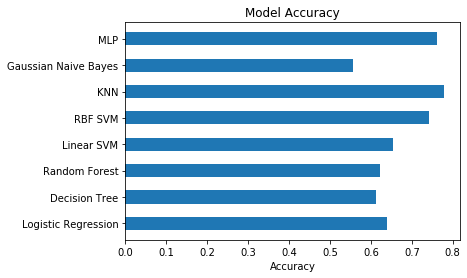

In [25]:
# Plot accuracy results
x = np.arange(len(clf))
plt.barh(x, acc, 0.5)
plt.yticks(x, clf)
plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.savefig('accuracy.jpg')
plt.show()

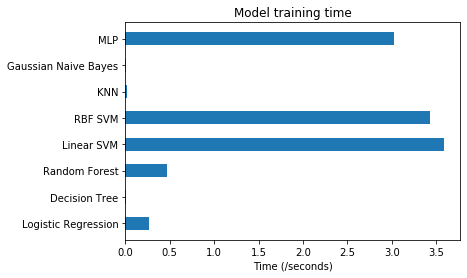

In [26]:
# Plot training time results
x = np.arange(len(clf))
plt.barh(x, training_time, 0.5)
plt.yticks(x, clf)
plt.title('Model training time')
plt.xlabel('Time (/seconds)')
plt.savefig('training_time.jpg')
plt.show()

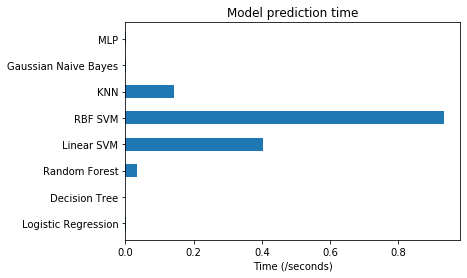

In [27]:
# Plot prediction time results
x = np.arange(len(clf))
plt.barh(x, pred_time, 0.5)
plt.yticks(x, clf)
plt.title('Model prediction time')
plt.xlabel('Time (/seconds)')
plt.savefig('prediction_time.jpg')
plt.show()

In [28]:
# Training KNN classifiers and tune the hyperparameters
# k-fold cross validation accuracy
l = [1, 3, 5, 7, 9, 11]
for k in l:
    knn_model = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn_model, X, y, cv=5)
    avg_score = sum(scores) / len(scores)
    print(str(k) + 'NN accuracy: ', avg_score)

1NN accuracy:  0.7708875070661391
3NN accuracy:  0.7794234030525721
5NN accuracy:  0.7790842283776145
7NN accuracy:  0.7752402487280949
9NN accuracy:  0.7741661955907293
11NN accuracy:  0.7739966082532505


In [29]:
# Training MLP classifiers and tune the hyperparameters
# k-fold cross validation accuracy
l = [5, 10, 20, 50, 100, 200]
for h in l:
    mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(h, 4), random_state=1)
    scores = cross_val_score(mlp_model, X, y, cv=5)
    avg_score = sum(scores) / len(scores)
    print('MLP accuracy with %d neurons hidden layer: %.4f' % (h, avg_score))

MLP accuracy with 5 neurons hidden layer: 0.7296
MLP accuracy with 10 neurons hidden layer: 0.7462
MLP accuracy with 20 neurons hidden layer: 0.7614
MLP accuracy with 50 neurons hidden layer: 0.7559
MLP accuracy with 100 neurons hidden layer: 0.7693
MLP accuracy with 200 neurons hidden layer: 0.7713


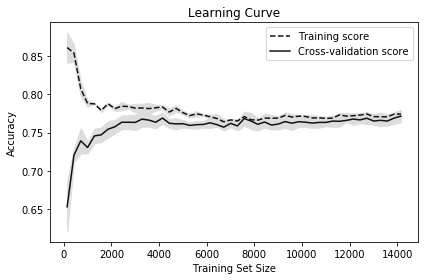

In [30]:
# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(mlp_model, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.savefig('learning_curve.jpg')
plt.show()

In [31]:
# Preprocess test data
preprocess_test_data = pd.DataFrame()
for k, group in test_data_raw.groupby(['installation_id', 'game_session']):
    df = group.sort_values(by=['event_count', 'game_time'])
    event_count = int(df['event_count'].iloc[-1])
    duration = int(df['game_time'].iloc[-1])
    installation_id = df['installation_id'].iloc[0]
    game_session = df['game_session'].iloc[0]
    title = df['title'].iloc[0]
    game_type = df['type'].iloc[0]
    world = df['world'].iloc[0]
    avg_event_code = df['event_code'].astype(np.int64).sum() / event_count
    preprocess_test_data = preprocess_test_data.append(pd.DataFrame({'installation_id': [installation_id], 
                                     'game_session': [game_session],
                                     'event_count': [event_count], 
                                     'duration': [duration],                                        
                                     'title': [title],
                                     'type': [game_type],
                                     'world': [world],
                                     'avg_event_code': [avg_event_code]}), ignore_index=True)  

In [32]:
# Convert categorical features to numeric
preprocess_test_data['title_num'] = preprocess_test_data['title'].apply(title_to_numeric)
preprocess_test_data['world_num'] = preprocess_test_data['world'].apply(world_to_numeric)

In [33]:
# Feature extraction
X_test = preprocess_test_data[['event_count', 'avg_event_code',
                           'duration', 'title_num', 'world_num']]
info = preprocess_test_data[['installation_id', 'game_session']]

In [34]:
X_test.head()

,event_count,avg_event_code,duration,title_num,world_num
0,1,2000.000000,0,3,2
1,26,3506.038462,30038,5,3
2,36,3271.972222,36926,3,2
3,1,2000.000000,0,5,3
4,51,3462.803922,38746,1,1


In [35]:
# Apply MLP model for prediction
mlp_model = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(200, 4), random_state=1)
mlp_model.fit(X, y)
X_test = scaler.transform(X_test)
y_pred = mlp_model.predict(X_test)

In [36]:
info['accuracy_group'] = y_pred

In [37]:
info.head()

,installation_id,game_session,accuracy_group
0,00abaee7,348d7f09f96af313,0
1,00abaee7,8b38fc0d2fd315dc,3
2,01242218,009c890ce6c4f3e3,3
3,01242218,1fef5d54cb4b775a,0
4,01242218,31423dbcd717919e,2


In [38]:
# Formatting output
output = pd.DataFrame()
for k, group in info.groupby(['installation_id']):
    installation_id = group['installation_id'].iloc[0]
    avg_acc_group = round(group['accuracy_group'].sum() / group.shape[0])
    output = output.append(pd.DataFrame({'installation_id': [installation_id],
                                         'accuracy_group': [avg_acc_group]}), ignore_index=True)

In [39]:
output['accuracy_group'] = output['accuracy_group'].astype(np.int64)

In [40]:
output.head()

,installation_id,accuracy_group
0,00abaee7,2
1,01242218,2
2,017c5718,0
3,01a44906,0
4,01bc6cb6,0


In [41]:
output.shape

(1000, 2)

In [42]:
# Count predicted labels
output['accuracy_group'].value_counts()

0    536
2    295
1    165
3    4  
Name: accuracy_group, dtype: int64

In [43]:
output.to_csv('submission.csv')

###################################################################
Approach2: Apply regression model to predict num_incorrect and classification 
model to predict num_correct; use these two columns to calculate 
the accuracy_group.
###################################################################

In [44]:
X = preprocess_train_data[['event_count', 'avg_event_code', 'duration', 'title_num', 'world_num']]
y1 = preprocess_train_data['num_correct']
y2 = preprocess_train_data['num_incorrect']
y = preprocess_train_data['accuracy_group']

In [45]:
# Normalize the raw data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [46]:
# Training a KNN classifier and predict 

knn_model = KNeighborsClassifier(n_neighbors = 5).fit(X, y1) 

knn_pred = knn_model.predict(X)

cm = confusion_matrix(y1, knn_pred, labels=[0, 1]) 
print('KNN confusion matrix: \n')
print(cm)
print(accuracy_score(y1, knn_pred))

KNN confusion matrix: 

[[ 3362   867]
 [  496 12965]]
0.9229508196721311


In [47]:
reg = Lasso(alpha=0.01).fit(X, y2)
reg_pred = reg.predict(X)

In [48]:
reg.score(X, y2)

0.473957260273483

In [49]:
reg.coef_

array([ 2.10735685,  0.00441341,  0.00756751,  0.18061818, -0.        ])

In [50]:
corr_pred = knn_model.predict(X)
incorr_pred = reg.predict(X)

In [51]:
incorr_pred = np.round(incorr_pred)

In [52]:
incorr_pred

array([1., 4., 1., ..., 2., 4., 4.])

In [53]:
y_pred = []

In [54]:
for i in range(len(corr_pred)):
    if list(corr_pred)[i] == 0:
        y_pred.append(0)
    else:
        if list(incorr_pred)[i] >= 2:
            y_pred.append(1)
        elif list(incorr_pred)[i] == 1:
            y_pred.append(2)
        else:
            y_pred.append(3)

In [55]:
y_pred = np.array(y_pred)

In [56]:
cm = confusion_matrix(y, y_pred, labels=[3, 2, 1, 0]) 

In [57]:
cm

array([[3320, 4559,  740,  226],
       [ 131, 1057,  918,   99],
       [  13,  301, 1926,  171],
       [ 101,  193,  573, 3362]])

In [58]:
accuracy_score(y, y_pred)

0.5463538722442057